<a href="https://colab.research.google.com/github/rtogn/A-Short-Cut-To-Mushrooms/blob/main/Mushroom_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [118]:
#@title Imports and global settings "A Short Cut to Mushrooms"
suppress_warnings = True #@param {type:"boolean"}
print_fields = True #@param {type:"boolean"}
display_cor_matrix = True #@param {type: "boolean"}
display_rocs = True #@param {type: "boolean"}
display_lcs = True #@param {type: "boolean"}
debug = False #@param {type:"boolean"}
encoder = "ordinal" #@param ["ordinal", "one_hot"]
seed = 1234 #@param {type:"integer"}
corr_drop_threshold = 0.1 #@param {type:"slider", min:0.0, max:1, step:0.05}
invert_corr = False #@param {type: "boolean"}

%matplotlib inline

import numpy as np
import pandas as pd
import sklearn 
import matplotlib.pyplot as plt

import warnings
if suppress_warnings:
  warnings.filterwarnings('ignore')

temp_tol = 0.0001 # Default
# In debug mode, go to quick mode for SVM training. 
if debug:
  temp_tol = 5.0

In [119]:
#@title Model Selection Interface (check = will be run)
dtree_on = True #@param {type:"boolean"}
rand_forest_on = True #@param {type:"boolean"}
nbayes_on = True #@param {type:"boolean"}
svm_lin_on = True #@param {type:"boolean"}
svm_rbf_on = False #@param {type:"boolean"}
gradient_boosting_on = False #@param {type:"boolean"}
knn_on = True #@param {type:"boolean"}
adaboost_on = False #@param {type:"boolean"}
x_val_n_folds = 3 #@param {type:"integer"}
predict_labels = ['Poisonous', 'Edible']




In [120]:
#@title Select Field To Predict
predict = "edible" #@param [ 'edible', 'cap-shape', 'cap-surface','cap-color', 'bruises', 'odor', 'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color', 'stalk-shape', 'stalk-root', 'stalk-surface-above-ring', 'stalk-surface-below-ring', 'stalk-color-above-ring', 'stalk-color-below-ring', 'veil-type', 'veil-color', 'ring-number', 'ring-type', 'spore-print-color', 'population', 'habitat']


In [121]:
# Load Dataset, discard essays.
from google.colab import drive
drive.mount('/content/drive')
file = 'drive/My Drive/csv/mushroom.csv'
df= pd.read_csv(file, encoding='utf-8')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [122]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

# Set up ordinal encoding for all fields in dataset
# Note- used for preditor field regardless of encoding used
ord_encoder = OrdinalEncoder()
ord_encoder.set_output(transform='pandas')
encoded_ordinal = ord_encoder.fit_transform(df)
#df.head
df.groupby('edible').count()

,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
edible,,,,,,,,,,,,,,,,,,,,,
e,4208,4208,4208,4208,4208,4208,4208,4208,4208,4208,...,4208,4208,4208,4208,4208,4208,4208,4208,4208,4208
p,3916,3916,3916,3916,3916,3916,3916,3916,3916,3916,...,3916,3916,3916,3916,3916,3916,3916,3916,3916,3916


In [123]:
corr_mat = encoded_ordinal.corr()
# Get sorted corelations by absolute value
top_corrs = corr_mat[[predict]].abs().sort_values(by=[predict], ascending=False)
# Remove predicted value as its corelation is 1
top_corrs.drop([predict], axis=0, inplace=True)

print("***Correlations for column being predicted***")
print(top_corrs)
drop_list = []
for i in top_corrs.index.values:
  corr_val = top_corrs[predict][i]
  attribute_name = i

  # Choose only low correlation features to test classification
  if invert_corr:
    if np.isnan(corr_val) or corr_val > corr_drop_threshold:
      drop_list.append(attribute_name)
  else:
      if np.isnan(corr_val) or corr_val < corr_drop_threshold:
        drop_list.append(attribute_name)

# Display list of items being dropped from set
print(f"***the following columns will be dropped from the dataset at threhsold {corr_drop_threshold}***")
print(drop_list)

# Display corrlation matrix for data and sorted list of correlations by abs value
# Note: this is done in a way that prints well in Colab,
# Normally would have to use a print command.
display_corr = None
if display_cor_matrix: 
  display_corr = corr_mat
display_corr

***Correlations for column being predicted***
                            edible
gill-size                 0.540024
gill-color                0.530566
bruises                   0.501530
ring-type                 0.411771
stalk-root                0.379361
gill-spacing              0.348387
stalk-surface-above-ring  0.334593
stalk-surface-below-ring  0.298801
population                0.298686
habitat                   0.217179
ring-number               0.214366
cap-surface               0.178446
spore-print-color         0.171961
stalk-color-above-ring    0.154003
stalk-color-below-ring    0.146730
veil-color                0.145142
gill-attachment           0.129200
stalk-shape               0.102019
odor                      0.093552
cap-shape                 0.052951
cap-color                 0.031384
veil-type                      NaN
***the following columns will be dropped from the dataset at threhsold 0.1***
['odor', 'cap-shape', 'cap-color', 'veil-type']


,edible,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
edible,1.000000,0.052951,0.178446,-0.031384,-0.501530,-0.093552,0.129200,-0.348387,0.540024,-0.530566,...,-0.298801,-0.154003,-0.146730,NaN,0.145142,-0.214366,-0.411771,0.171961,0.298686,0.217179
cap-shape,0.052951,1.000000,-0.050454,-0.048203,-0.035374,-0.021935,0.078865,0.013196,0.054050,-0.006039,...,-0.032591,-0.031659,-0.030390,NaN,0.072560,-0.106534,-0.025457,-0.073416,0.063413,-0.042221
cap-surface,0.178446,-0.050454,1.000000,-0.019402,0.070228,0.045233,-0.034180,-0.282306,0.208100,-0.161017,...,0.107965,0.066050,0.068885,NaN,-0.016603,-0.026147,-0.106407,0.230364,0.021555,0.163887
cap-color,-0.031384,-0.048203,-0.019402,1.000000,-0.000764,-0.387121,0.041436,0.144259,-0.169464,0.084659,...,-0.047710,0.002364,0.008057,NaN,0.036130,-0.005822,0.162513,-0.293523,-0.144770,0.033925
bruises,-0.501530,-0.035374,0.070228,-0.000764,1.000000,-0.061825,0.137359,-0.299473,-0.369596,0.527120,...,0.458983,0.083538,0.092874,NaN,0.119770,0.056788,0.692973,-0.285008,0.088137,-0.075095
odor,-0.093552,-0.021935,0.045233,-0.387121,-0.061825,1.000000,-0.059590,0.063936,0.310495,-0.129213,...,0.061820,0.174532,0.169407,NaN,-0.057747,0.111905,-0.281387,0.469055,-0.043623,-0.026610
gill-attachment,0.129200,0.078865,-0.034180,0.041436,0.137359,-0.059590,1.000000,0.071489,0.108984,-0.128567,...,-0.116177,0.099299,0.097160,NaN,0.897518,0.093236,-0.146689,-0.029524,0.165575,-0.030304
gill-spacing,-0.348387,0.013196,-0.282306,0.144259,-0.299473,0.063936,0.071489,1.000000,-0.108333,0.100193,...,-0.213775,0.274574,0.253505,NaN,0.073363,0.243014,-0.195897,0.047323,-0.529253,-0.154680
gill-size,0.540024,0.054050,0.208100,-0.169464,-0.369596,0.310495,0.108984,-0.108333,1.000000,-0.516736,...,0.010894,0.296548,0.278708,NaN,0.103809,-0.171362,-0.460872,0.622991,0.147682,0.161418
gill-color,-0.530566,-0.006039,-0.161017,0.084659,0.527120,-0.129213,-0.128567,0.100193,-0.516736,1.000000,...,0.257224,-0.058299,-0.074781,NaN,-0.097583,0.096054,0.629398,-0.416135,-0.034090,-0.202972


In [124]:
# Drop columns with correlations that dont reach threshold or are invalid:
for col in drop_list:
  encoded_ordinal.drop([col], axis=1, inplace=True)

In [125]:
'''
'edible', 'cap-shape', 'cap-surface', 'cap-color', 'bruises', 'odor', 'gill-attachment', 'gill-spacing', 'gill-size', 'gill-color', 'stalk-shape',
'stalk-root', 'stalk-surface-above-ring', 'stalk-surface-below-ring', 'stalk-color-above-ring', 'stalk-color-below-ring',
'veil-type', 'veil-color', 'ring-number', 'ring-type', 'spore-print-color', 'population', 'habitat'
'''
if encoder == 'ordinal':
  X = encoded_ordinal.drop([predict], axis=1, inplace=False)
else:
  # Set up One-hot encoding for dataset
  df_1Hot = encoded_ordinal.loc[:,encoded_ordinal.columns != predict]
  enc_1hot = pd.get_dummies(df_1Hot, columns = df_1Hot.columns)
  X = enc_1hot

X_less_features = X
y= encoded_ordinal[predict]


# If print_fields at top is checked print out field info
if print_fields:
  print("***Attributes in dataset***")
  for item in X.columns:
    print(item)

X.head()



***Attributes in dataset***
cap-surface
bruises
gill-attachment
gill-spacing
gill-size
gill-color
stalk-shape
stalk-root
stalk-surface-above-ring
stalk-surface-below-ring
stalk-color-above-ring
stalk-color-below-ring
veil-color
ring-number
ring-type
spore-print-color
population
habitat


,cap-surface,bruises,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,2.0,1.0,1.0,0.0,1.0,4.0,0.0,3.0,2.0,2.0,7.0,7.0,2.0,1.0,4.0,2.0,3.0,5.0
1,2.0,1.0,1.0,0.0,0.0,4.0,0.0,2.0,2.0,2.0,7.0,7.0,2.0,1.0,4.0,3.0,2.0,1.0
2,2.0,1.0,1.0,0.0,0.0,5.0,0.0,2.0,2.0,2.0,7.0,7.0,2.0,1.0,4.0,3.0,2.0,3.0
3,3.0,1.0,1.0,0.0,1.0,5.0,0.0,3.0,2.0,2.0,7.0,7.0,2.0,1.0,4.0,2.0,3.0,5.0
4,2.0,0.0,1.0,1.0,0.0,4.0,1.0,3.0,2.0,2.0,7.0,7.0,2.0,1.0,0.0,3.0,0.0,1.0


In [126]:
from sklearn.model_selection import train_test_split

#splits 50/50, 70/30, 60/40, 80/20
class split:
  def __init__(self, X, y, test_size, seed_state):
    self.name = "split_" + str(1-test_size) + "/" + str(test_size)
    self.test_size = test_size
    self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(X, y, test_size=test_size, random_state=seed_state, shuffle=True)

s1 = split(X, y, .5, seed)
s2 = split(X, y, .4, seed)
s3 = split(X, y, .3, seed)
#s4 = split(X, y, .2, seed)
splits = [s1, s2, s3] #, s4]


In [127]:
#@title Display Functions and Model class 
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold, cross_val_score, StratifiedKFold
from sklearn.model_selection import LearningCurveDisplay, learning_curve, ShuffleSplit
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc

def get_name(model):
  name = type(model).__name__
  if name == "SVC":
    name = "SVM, " + model.kernel + " kernel"
  return name

def learning_curve_display(classifier, split_name, X, y):
  fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 6), sharey=True)

  common_params = {
      "X": X,
      "y": y,
      "train_sizes": np.linspace(0.1, 1.0, 5),
      "cv": StratifiedKFold(n_splits=x_val_n_folds, random_state=seed, shuffle=True),
      "score_type": "both",
      "n_jobs": 4,
      "line_kw": {"marker": "o"},
      "std_display_style": "fill_between",
      "score_name": "Accuracy"
  }
  #for ax_idx, estimator in enumerate([classifier]):
  LearningCurveDisplay.from_estimator(classifier, **common_params, ax=ax)
  handles, label = ax.get_legend_handles_labels()
  ax.legend(handles[:2], ["Training Score", "Test Score"])
  ax.set_title(f"Learning Curve for Model: {get_name(classifier)} at split: {split_name}")

class ml_model:
  # Class params: unfit sklearn model and a split class object (see above)
  # methods: 
  #  x_val - takes # of folds and runs cross_calidation for the model using the given split
  #          returns test_scores (and sets class instance)
  #  get_best_model - returns the best model choice from cross validation folds (hence known as a bff)
  #  learn_curve - displays learning curve graph for the model. Should rename to learning_curve but its too annoying at this point.
  #  class_report - prints out classification report for the model
  def __init__(self, model, split):
    self.model = model
    self.name = type(model).__name__
    #self.model.fit(X, y)
    self.split = split
    self.test_scores = None
    self.display = None
    # bff = Best Model From Fold 
    self.bff = None
    
  def x_val(self, folds):
    s = ShuffleSplit(n_splits=folds, test_size=self.split.test_size, random_state=seed)
    self.test_scores = cross_validate(self.model, self.split.X_train, self.split.y_train, cv=s, return_train_score=True, return_estimator=True)
    # self.train_score = cross_validate(self.model, self.split.X_train, self.split.y_train, cv=folds)
    return self.test_scores #, self.train_score
    
  def get_best_model(self):
    # Return best model from cros val split as dict including test and train score from X-validation.
    scores = self.test_scores['test_score']
    max_score = max(scores)
    # If the scores are equal, just take the first one...awkwardly. 
    where = np.where(scores == max_score)
    try:
      index_of_max = where[0].item()
    except:
      # Keep running into a strange bug with this. If this errors out select 80/20 split by default
      index_of_max=2
    best_model = self.test_scores['estimator'][index_of_max]
    self.bff = {'estimator':best_model, 'test_score':max_score, 'train_score':self.test_scores['train_score'][index_of_max]}
    return self.bff
  
  def roc(self):
    # Compute ROC curve and ROC area for each class
    classifier = self.model
    X_data = self.split.X_train
    y_data = self.split.y_train
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    classifier.fit(X_data, y_data)
    try:
      y_score = classifier.decision_function(X_data)
    except:
      y_score = classifier.predict(X_data)

    for i in range(1):
        fpr[i], tpr[i], _ = roc_curve(y_data, y_score)
        roc_auc[i] = auc(fpr[i], tpr[i])
        
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_data.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    plt.figure()
    lw = 2
    plt.plot(fpr[0], tpr[0], color='darkorange',
            lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    #plt.xlim([0.0, 1.0])
    #plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve for ' + self.name + ' model')
    plt.legend(loc="lower right")
    plt.show()

  def learn_curve(self):  
    learning_curve_display(self.model, self.split.name, self.split.X_train, self.split.y_train)
    #train_sizes, train_scores, test_scores = learning_curve(self.model, self.split.X_test, self.split.y_test)
    #self.display = LearningCurveDisplay(train_sizes=train_sizes, train_scores=train_scores, test_scores=test_scores, score_name="Score")
    #self.display.plot()
    #plt.show()

  def class_report(self):
    predictions = self.bff['estimator'].predict(self.split.X_test)
    print(classification_report(self.split.y_test, predictions))#target_names=(predict_labels[0], predict_labels[1]

  def metrics(self):
    self.class_report()
    if display_rocs:
      self.roc()
    if display_lcs:
      self.learn_curve()
    
  
models = []

****************************************************************************<br>
BELOW ARE BLOCKS FOR EACH MODEL. IF YOU DONT WANT TO RUN ALL OF THEM, JUST SELECT THE ONES YOU WANT AND THEY WILL BE APPENDED TO MODELS. BTW LOWERCASE IS FOR WEAKLINGS.<br>
****************************************************************************<br>

In [128]:
#@title K Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier
KNN = KNeighborsClassifier(n_neighbors=4)

if knn_on:
  models.append(KNN)

In [129]:
#@title Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier(criterion="gini", random_state=seed, max_depth=6)
dtree2 = DecisionTreeClassifier(criterion="entropy", random_state=seed, max_depth=6)
if dtree_on:
  models.append(dtree)

In [130]:
#@title Random Forest
from sklearn.ensemble import RandomForestClassifier

rforest = RandomForestClassifier( random_state=seed)

if rand_forest_on:
  models.append(rforest)

In [131]:
#@title Naive Bayes Classifier
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()

if nbayes_on:
  models.append(nb)

In [132]:
#@title SVM W/ Linear Kernel
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html
# https://sijanb.com.np/posts/understanding-regularization-for-support-vector-machines-svms/
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

svm_lin = LinearSVC(random_state=seed, tol=temp_tol, C=0.25)

if svm_lin_on:
  models.append(svm_lin)

In [133]:
#@title SVM W/ RBF Kernel
# https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
from sklearn import svm
svm_rbf = svm.SVC(kernel='rbf', random_state=seed, tol=temp_tol)

if svm_rbf_on:
  models.append(svm_rbf) #= [svm_lin, svm_rbf]#{'svm_lin':svm_lin, 'svm_rbf':svm_rbf}

In [134]:
#@title AdaBoost
from sklearn.ensemble import AdaBoostClassifier
ada_boost = AdaBoostClassifier(n_estimators=100)

if adaboost_on:
  models.append(ada_boost)

**End Model section**

In [135]:
def get_best_of_splits(split_list):
  # dumb way to get the best model from a list of best from folds from Model obj.
  # Since the split list includes the Split reference itself as item 2, 
  # Refer to item 0 to actually check the estimator itself.
  cur_best = split_list[0]
  for est_items in split_list:
    if est_items['bff']['test_score'] > cur_best['bff']['test_score']:
      cur_best = est_items
  return cur_best

*********************************************
Model: KNeighborsClassifier at split: split_0.5/0.5
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2105
         1.0       1.00      0.99      1.00      1957

    accuracy                           1.00      4062
   macro avg       1.00      1.00      1.00      4062
weighted avg       1.00      1.00      1.00      4062



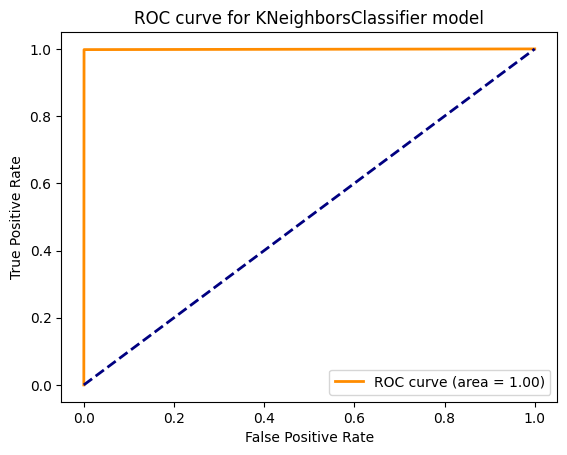

*********************************************
Model: KNeighborsClassifier at split: split_0.6/0.4
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00      1680
         1.0       1.00      0.99      1.00      1570

    accuracy                           1.00      3250
   macro avg       1.00      1.00      1.00      3250
weighted avg       1.00      1.00      1.00      3250



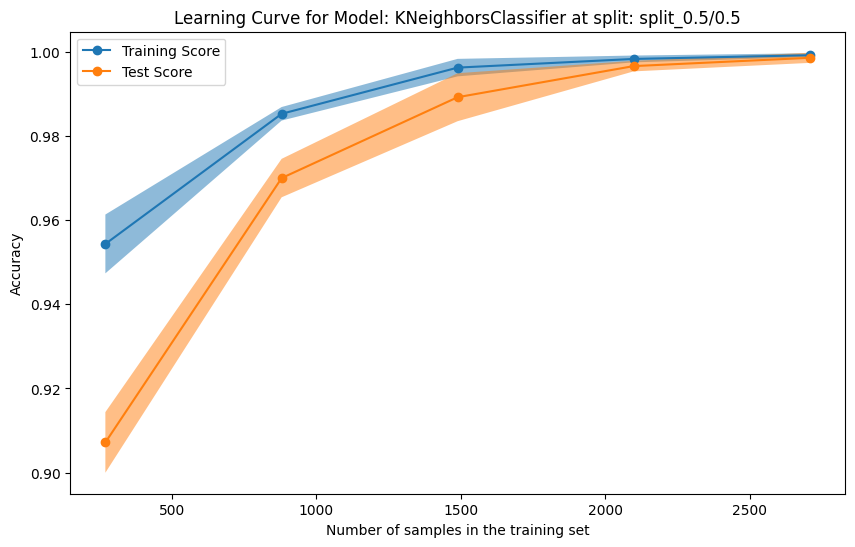

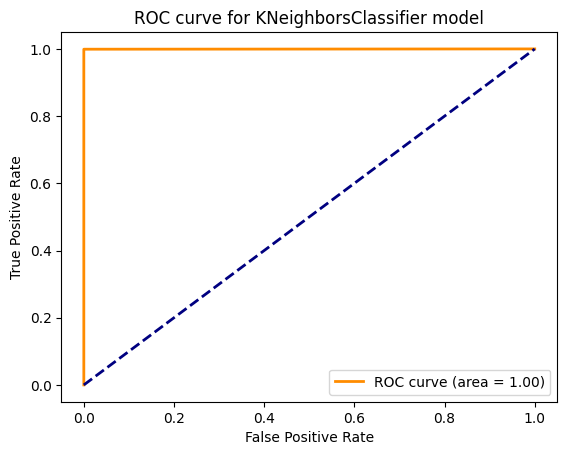

*********************************************
Model: KNeighborsClassifier at split: split_0.7/0.3
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1252
         1.0       1.00      1.00      1.00      1186

    accuracy                           1.00      2438
   macro avg       1.00      1.00      1.00      2438
weighted avg       1.00      1.00      1.00      2438



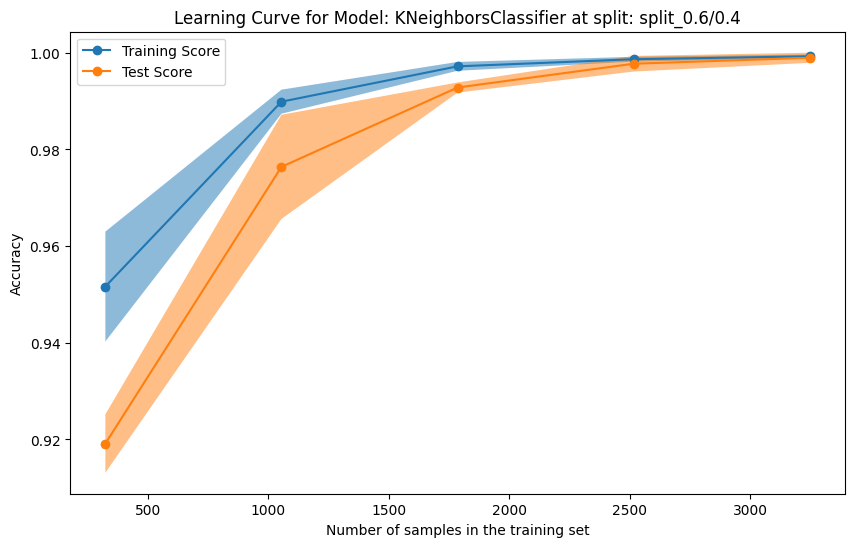

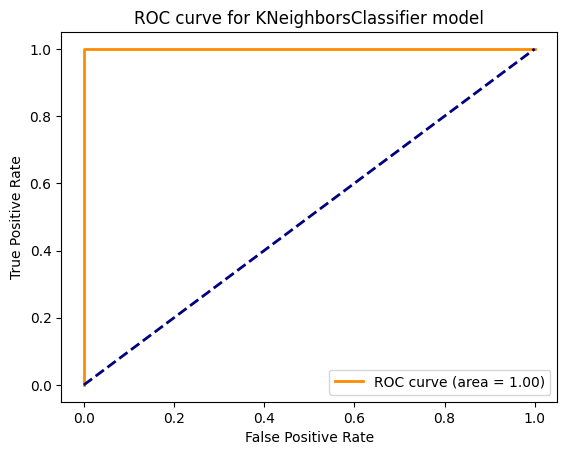

*********************************************
*********************************************
Model: DecisionTreeClassifier at split: split_0.5/0.5
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2105
         1.0       1.00      1.00      1.00      1957

    accuracy                           1.00      4062
   macro avg       1.00      1.00      1.00      4062
weighted avg       1.00      1.00      1.00      4062



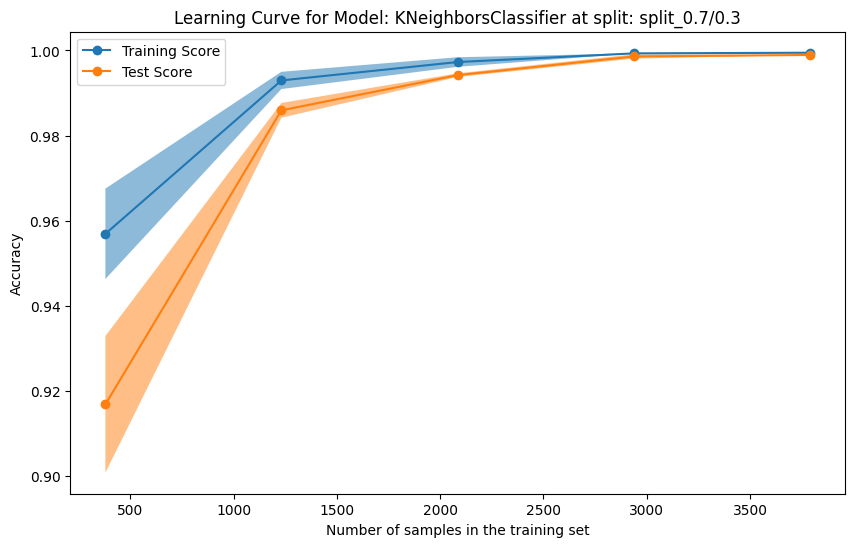

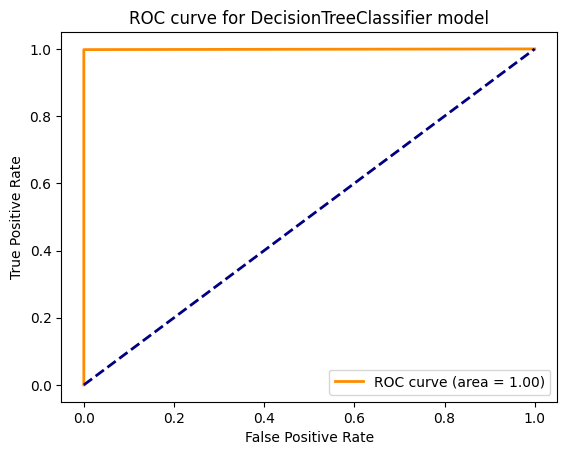

*********************************************
Model: DecisionTreeClassifier at split: split_0.6/0.4
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1680
         1.0       1.00      1.00      1.00      1570

    accuracy                           1.00      3250
   macro avg       1.00      1.00      1.00      3250
weighted avg       1.00      1.00      1.00      3250



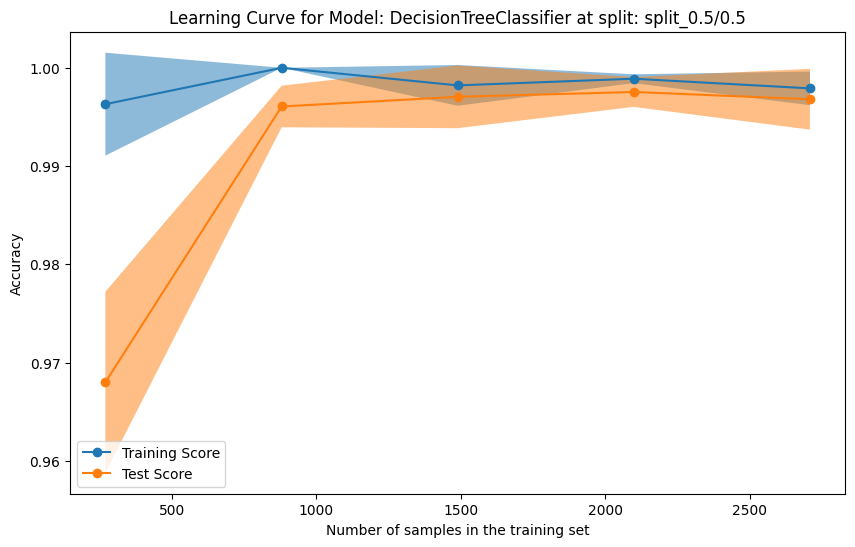

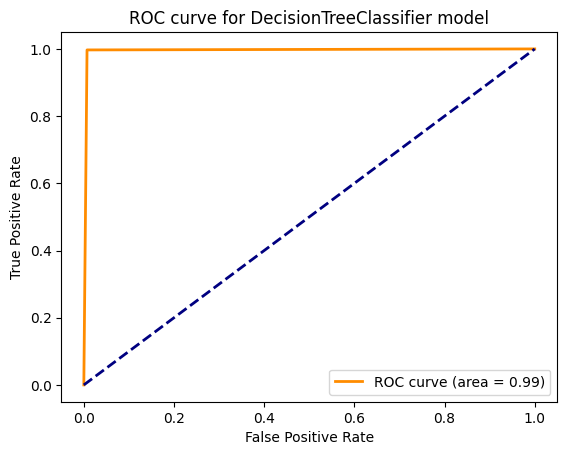

*********************************************
Model: DecisionTreeClassifier at split: split_0.7/0.3
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1252
         1.0       1.00      1.00      1.00      1186

    accuracy                           1.00      2438
   macro avg       1.00      1.00      1.00      2438
weighted avg       1.00      1.00      1.00      2438



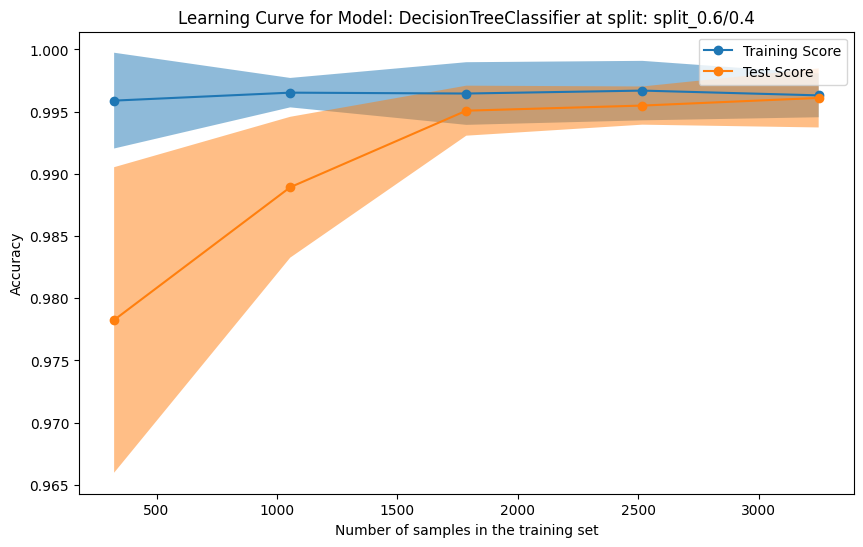

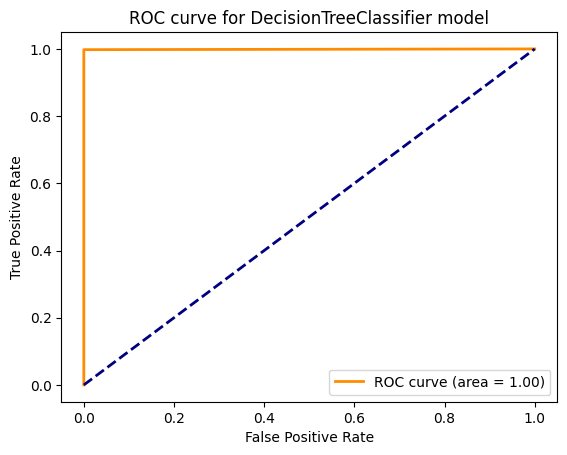

*********************************************
*********************************************
Model: RandomForestClassifier at split: split_0.5/0.5
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      2105
         1.0       1.00      1.00      1.00      1957

    accuracy                           1.00      4062
   macro avg       1.00      1.00      1.00      4062
weighted avg       1.00      1.00      1.00      4062



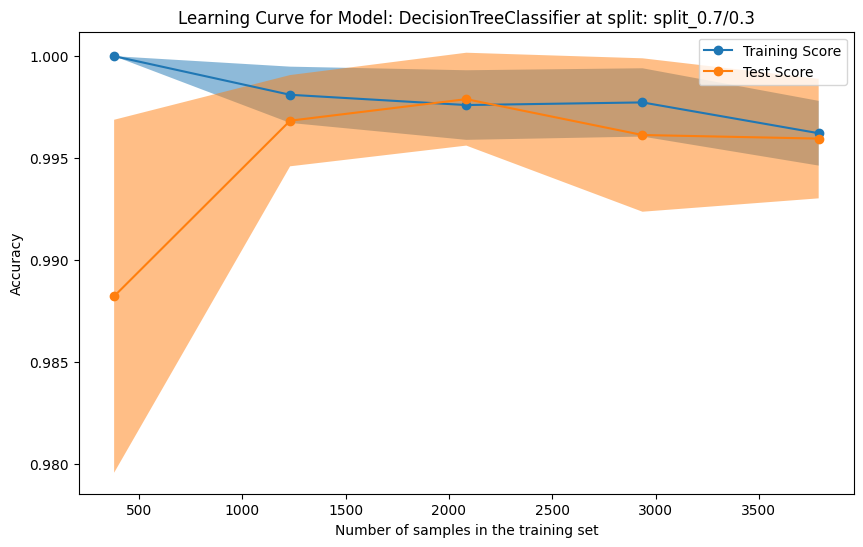

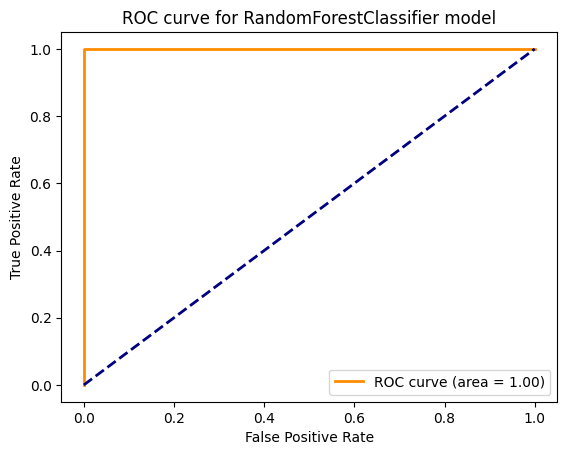

*********************************************
Model: RandomForestClassifier at split: split_0.6/0.4
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1680
         1.0       1.00      1.00      1.00      1570

    accuracy                           1.00      3250
   macro avg       1.00      1.00      1.00      3250
weighted avg       1.00      1.00      1.00      3250



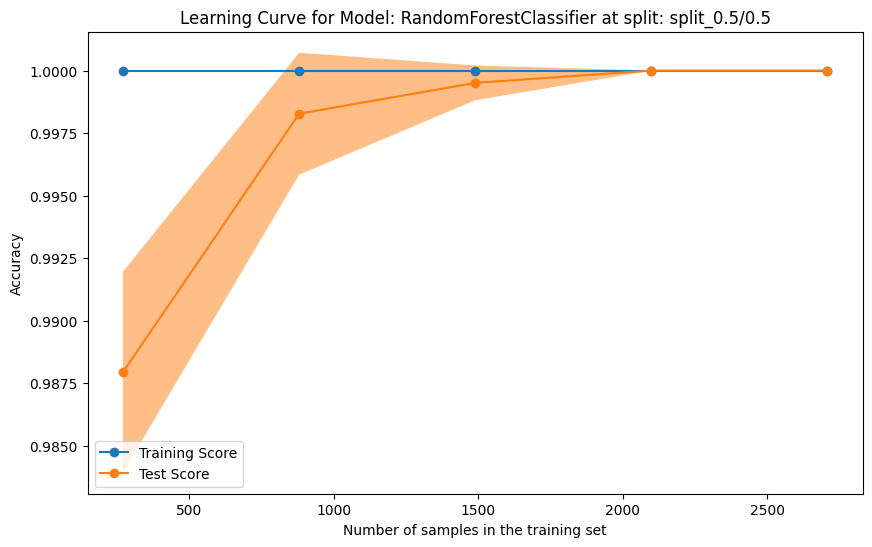

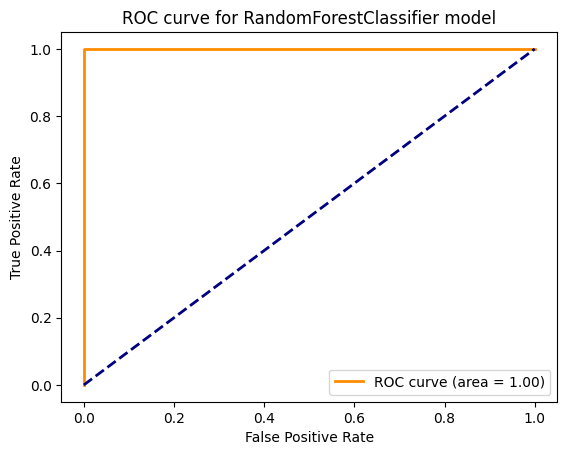

*********************************************
Model: RandomForestClassifier at split: split_0.7/0.3
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1252
         1.0       1.00      1.00      1.00      1186

    accuracy                           1.00      2438
   macro avg       1.00      1.00      1.00      2438
weighted avg       1.00      1.00      1.00      2438



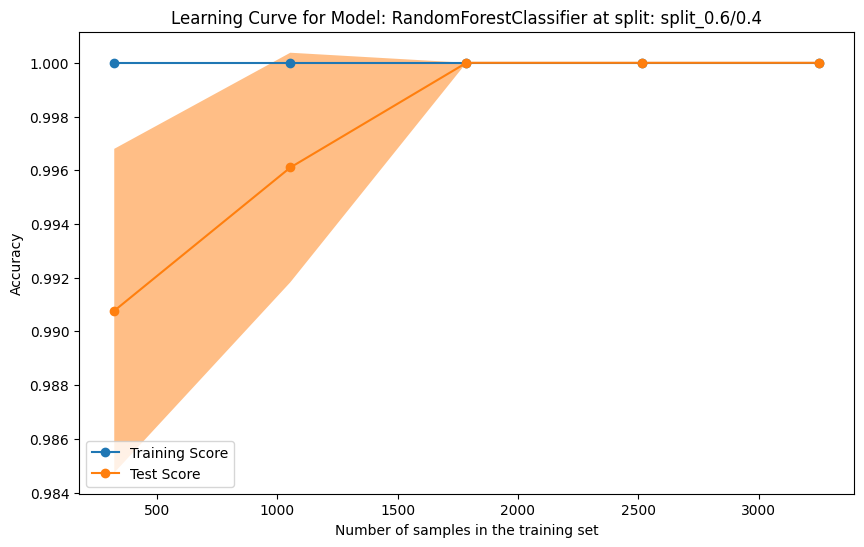

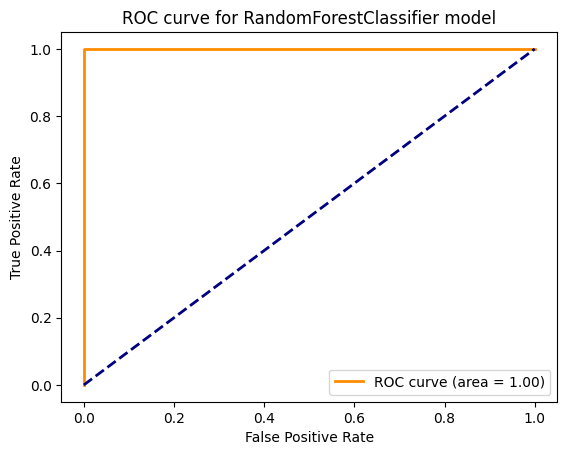

*********************************************
*********************************************
Model: GaussianNB at split: split_0.5/0.5
              precision    recall  f1-score   support

         0.0       0.93      0.92      0.92      2105
         1.0       0.92      0.92      0.92      1957

    accuracy                           0.92      4062
   macro avg       0.92      0.92      0.92      4062
weighted avg       0.92      0.92      0.92      4062



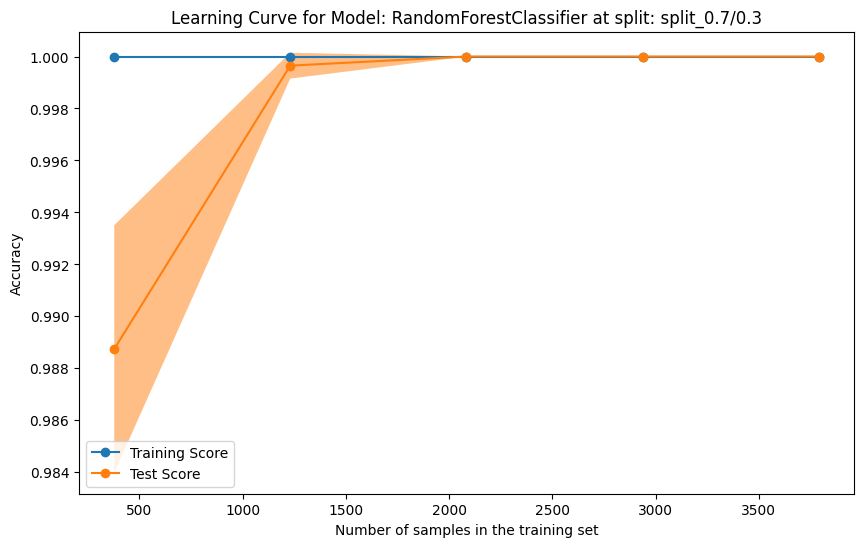

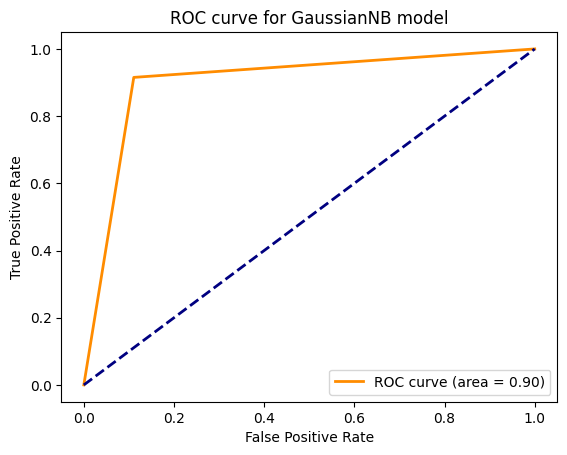

*********************************************
Model: GaussianNB at split: split_0.6/0.4
              precision    recall  f1-score   support

         0.0       0.93      0.86      0.89      1680
         1.0       0.86      0.93      0.89      1570

    accuracy                           0.89      3250
   macro avg       0.89      0.89      0.89      3250
weighted avg       0.90      0.89      0.89      3250



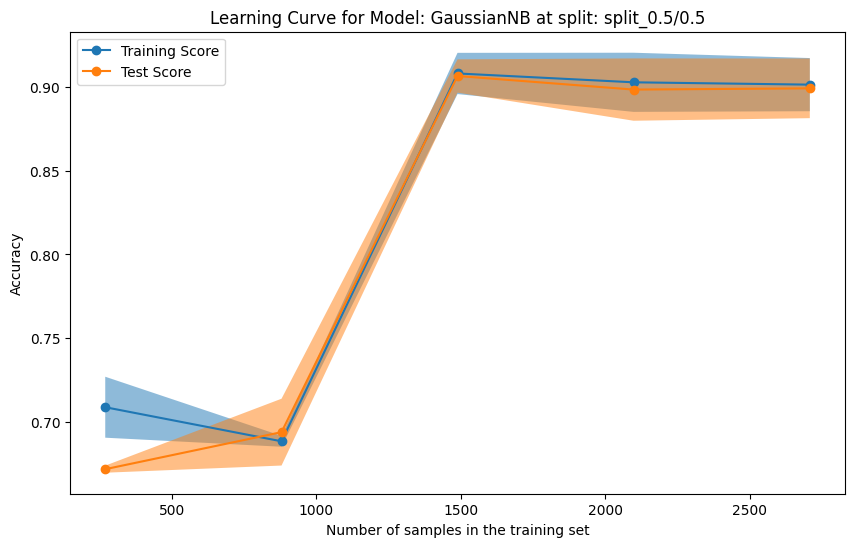

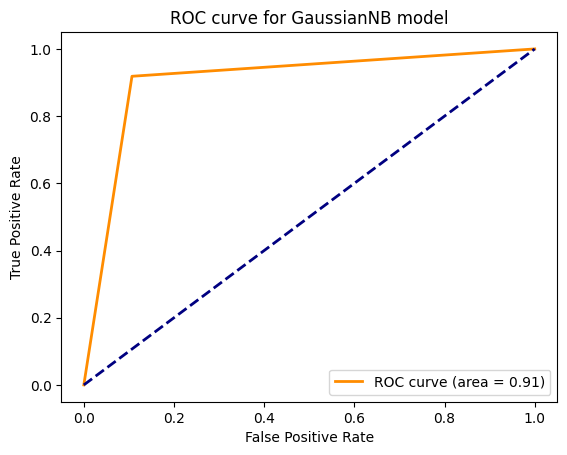

*********************************************
Model: GaussianNB at split: split_0.7/0.3
              precision    recall  f1-score   support

         0.0       0.92      0.92      0.92      1252
         1.0       0.92      0.91      0.92      1186

    accuracy                           0.92      2438
   macro avg       0.92      0.92      0.92      2438
weighted avg       0.92      0.92      0.92      2438



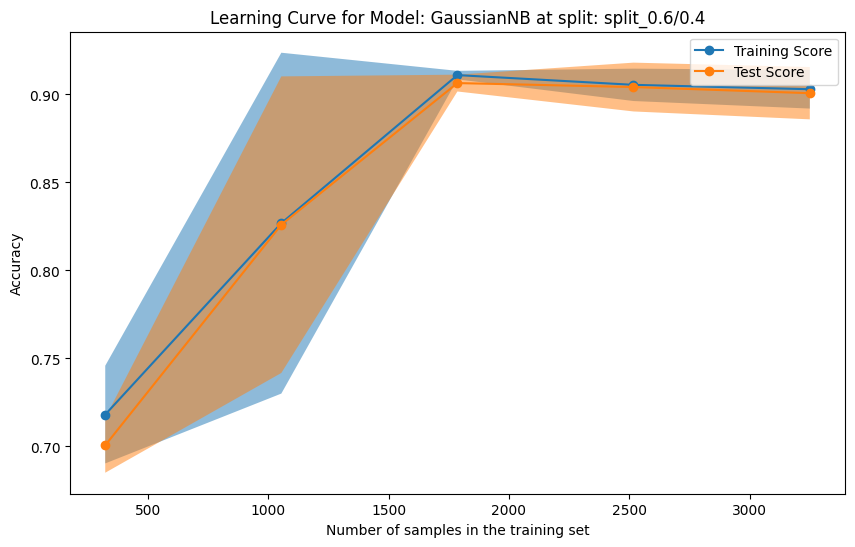

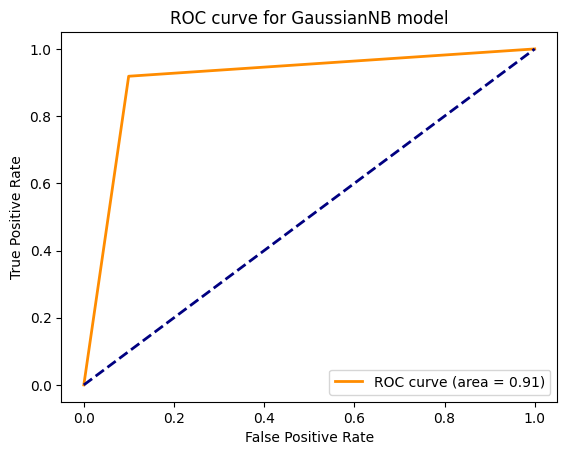

*********************************************
*********************************************
Model: LinearSVC at split: split_0.5/0.5
              precision    recall  f1-score   support

         0.0       0.94      0.96      0.95      2105
         1.0       0.95      0.94      0.95      1957

    accuracy                           0.95      4062
   macro avg       0.95      0.95      0.95      4062
weighted avg       0.95      0.95      0.95      4062



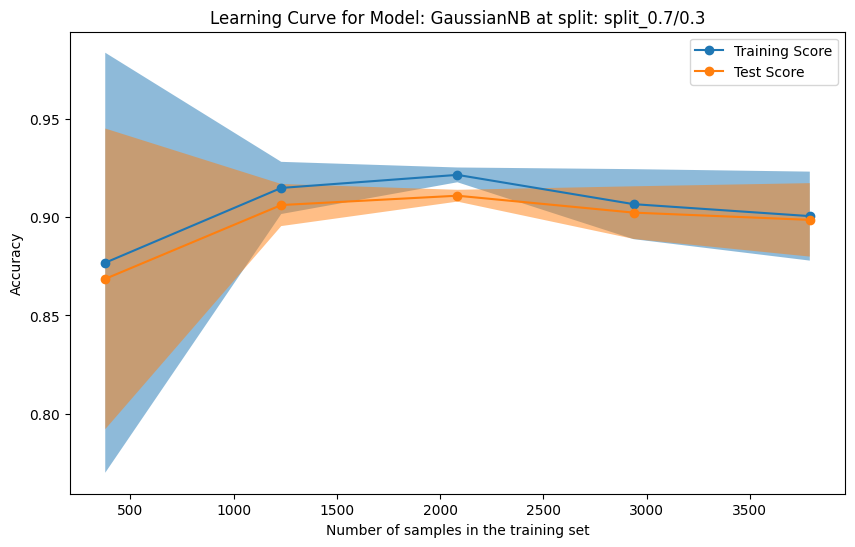

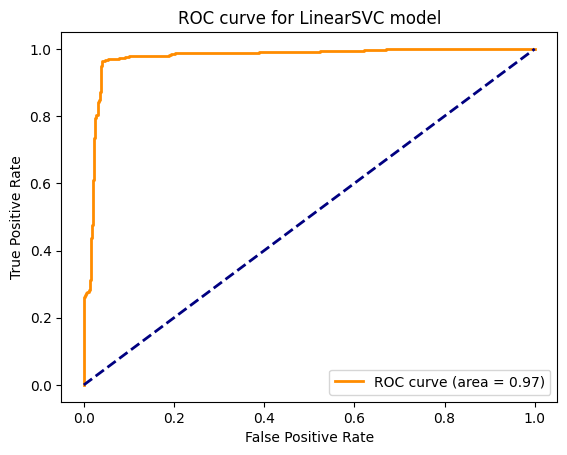

*********************************************
Model: LinearSVC at split: split_0.6/0.4
              precision    recall  f1-score   support

         0.0       0.94      0.96      0.95      1680
         1.0       0.96      0.93      0.94      1570

    accuracy                           0.95      3250
   macro avg       0.95      0.95      0.95      3250
weighted avg       0.95      0.95      0.95      3250



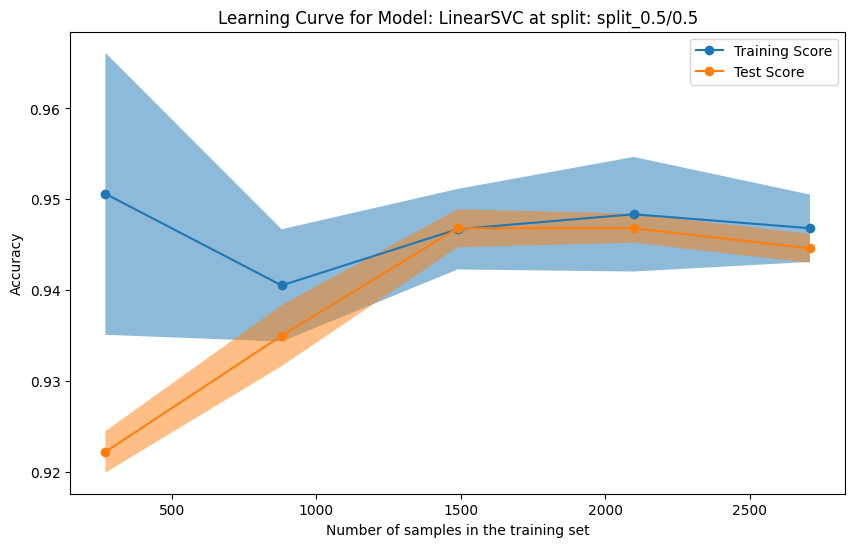

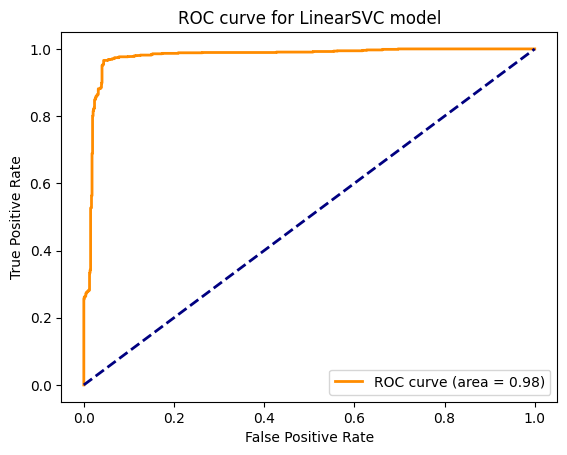

*********************************************
Model: LinearSVC at split: split_0.7/0.3
              precision    recall  f1-score   support

         0.0       0.93      0.96      0.94      1252
         1.0       0.95      0.92      0.94      1186

    accuracy                           0.94      2438
   macro avg       0.94      0.94      0.94      2438
weighted avg       0.94      0.94      0.94      2438



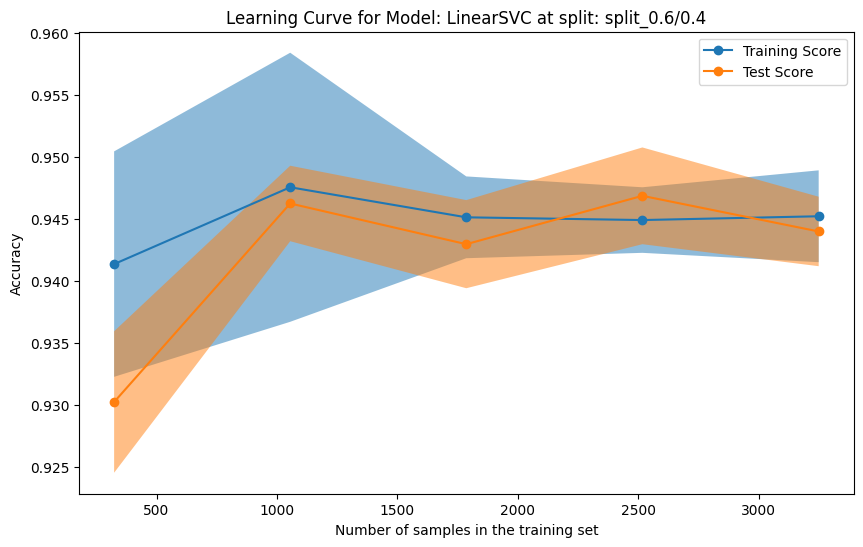

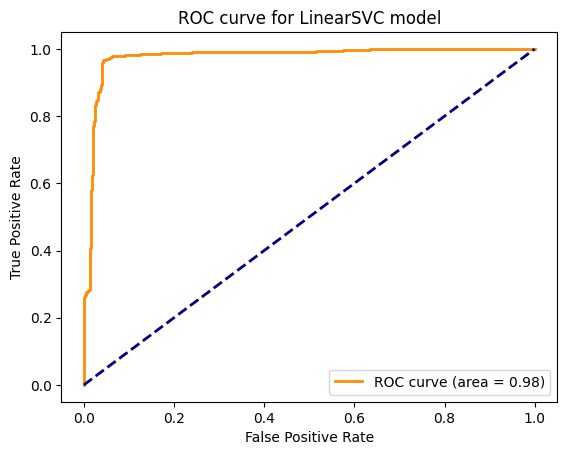

*********************************************


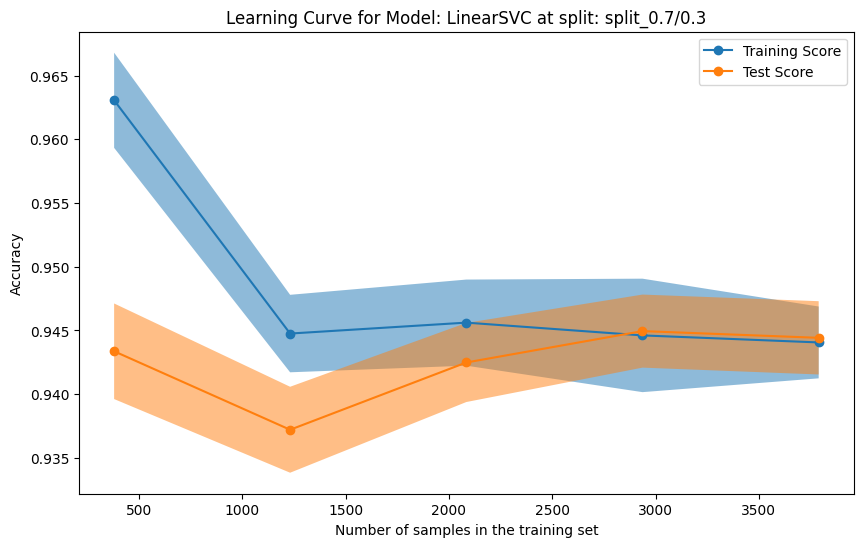

In [136]:
models_supremum = []
for model in models:
  mod_name = get_name(model)
  split_bests = []
  for i in range(0, len(splits)):
    split = splits[i]
    cur = ml_model(model, split)
    print("*********************************************")
    print("Model: " + cur.name + " at split: " + split.name)
    tests = cur.x_val(x_val_n_folds)
    b = cur.get_best_model()
    # Pass the winning object and its split so that metrics can be done 
    # correctly with that exact split data later. 
    split_bests.append({'bff':b, 'split':split})
    #print(b['estimator'].predict(split.X_test))
    cur.metrics()
  print("*********************************************")
  models_supremum.append(get_best_of_splits(split_bests))
  


In [137]:
from sklearn.metrics import precision_recall_fscore_support as prf
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics._plot.confusion_matrix import ConfusionMatrixDisplay

def plot_confusion_matrix(estimator, X_test, y_test): 
  # Special thanks to https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
  # For how to set the individual titles correctly
  display = ConfusionMatrixDisplay.from_estimator(
      estimator,
      X_test,
      y_test,
      cmap=plt.cm.Blues,
    )
  title = "Confusion matrix for the best " + get_name(estimator)
  display.ax_.set_title(title)
  plt.show()


def get_metrics_one(estimator, X_test, y_test):
  predictions = estimator.predict(X_test)
  model_acc = accuracy_score(y_test, predictions)
  models_prf = prf(y_test, predictions, average='macro')
  RMSE = mean_squared_error(y_test, predictions, squared=False) # Squared=False sets to RMSE mode
  return {'name':type(estimator).__name__, 'accuracy':model_acc, 'precision':models_prf[0], 'recall':models_prf[1], 'F1':models_prf[2], 'RMSE':RMSE}

def get_metrics_all(models_supremum):
  # Put together all the metrics into a dataframe for all winning models
  # And print out the confusion matrix
  # Im pretty sure this is a dumb way to do this but it works and I'm sick trying. 
  names = []
  acc = []
  prec = []
  rec = []
  F1 = []
  rmse = []
  #info = []
  for est_items in models_supremum:
    estimator = est_items['bff']['estimator']
    split = est_items['split']
    plot_confusion_matrix(estimator, split.X_test, split.y_test)
    cur = get_metrics_one(estimator, split.X_test, split.y_test)
    
    # Distinguish SVMs from each other. 
    name = cur['name']
    if name == "SVC":
      name = "SVM, " + estimator.kernel + " Kernel" 

    # Add split
    name = name + ", split=" + split.name 

    names.append(name)
    acc.append(cur['accuracy'])
    prec.append(cur['precision'])
    rec.append(cur['recall'])
    F1.append(cur['F1'])
    rmse.append(cur['RMSE'])

    
    #info.append()

  aggregate = {'Model Name':names, 
              'Accuracy':acc, 
              'Precision':prec,
              'Recall':rec, 
              'F1-score':F1, 
              'RMSE':rmse}

  df = pd.DataFrame(data=aggregate)
  return df #This looks nicer than a console print, at least in this notebook.



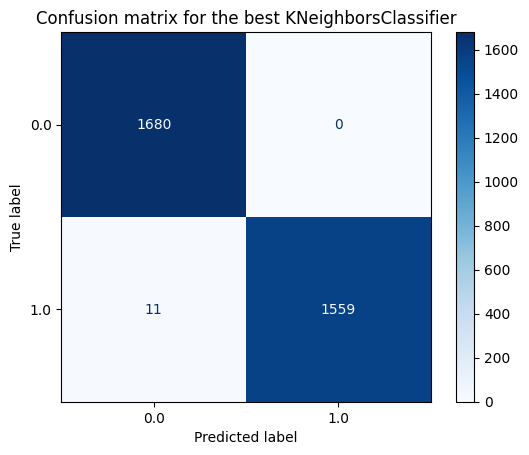

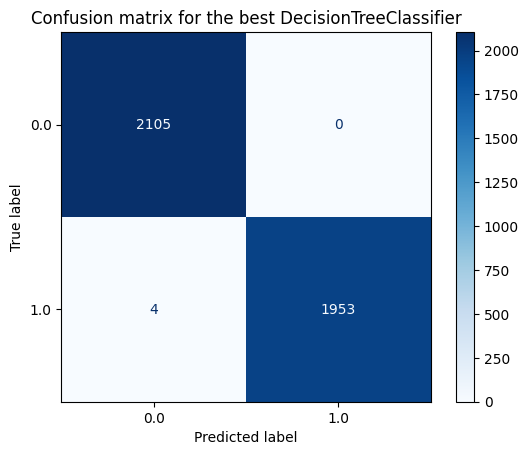

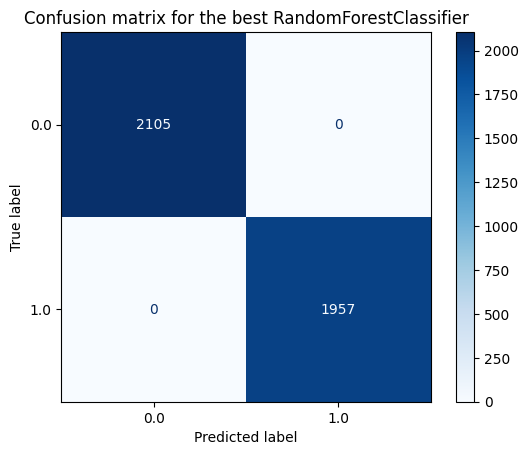

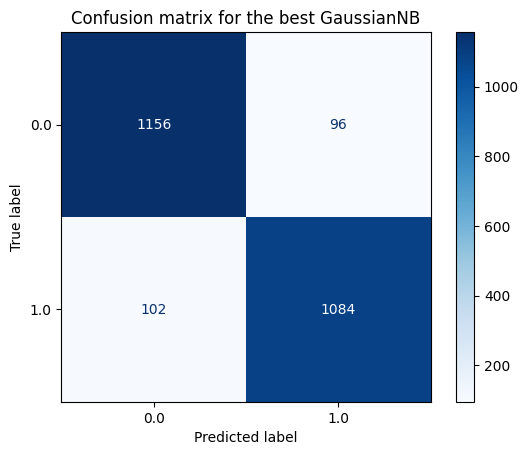

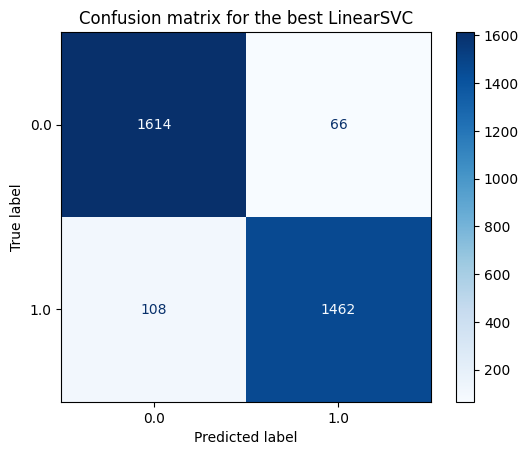

,Model Name,Accuracy,Precision,Recall,F1-score,RMSE
0,"KNeighborsClassifier, split=split_0.6/0.4",0.996615,0.996747,0.996497,0.996611,0.058177
1,"DecisionTreeClassifier, split=split_0.5/0.5",0.999015,0.999052,0.998978,0.999014,0.031381
2,"RandomForestClassifier, split=split_0.5/0.5",1.000000,1.000000,1.000000,1.000000,0.000000
3,"GaussianNB, split=split_0.7/0.3",0.918786,0.918781,0.918660,0.918715,0.284981
4,"LinearSVC, split=split_0.6/0.4",0.946462,0.947044,0.945962,0.946344,0.231384


In [138]:
# And finally
final_mets = get_metrics_all(models_supremum)
final_mets